# Import necessary libraries


In [1]:
import torch
import torchvision.datasets as datasets

from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data
from torchvision.transforms import v2, functional
from torch._tensor import Tensor
from typing import Literal
from collections import Counter, ChainMap

from sklearn import metrics, decomposition, manifold
from tqdm.autonotebook import tqdm, trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import pprint
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup seed


In [3]:
SEED = 21110308

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Common function


In [4]:
def imshows(imgs, figsize=None, title: str = None) -> None:
    fig = plt.figure(figsize=figsize)
    n_images = len(imgs)

    rows = cols = int(np.sqrt(n_images))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(imgs[i].view(28, 28).cpu().numpy(), cmap="bone")
        ax.axis("off")
    plt.title(title)


def count_parameters(model) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time) -> tuple[int, int]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def get_predictions(model, iterator, device) -> tuple[Tensor, Tensor, Tensor]:
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for x, y in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs


def plot_confusion_matrix(labels, pred_labels) -> None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, range(10))
    cm.plot(values_format="d", cmap="Blues", ax=ax)
    return


def show_most_incorrect(incorrect, n_images) -> None:
    rows = cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap="bone")
        ax.set_title(
            f"true label: {true_label} ({true_prob:.3f})\n"
            f"preb label: {incorrect_label} ({incorrect_prob:.3f})"
        )
        ax.axis("off")
    fig.subplots_adjust(hspace=0.5)
    return


def get_pca(data, n_components=2) -> np.ndarray:
    pca = decomposition.PCA()
    pca.n_components_ = n_components
    pca_data = pca.fit_transform(data)
    return pca_data


def plot_representations(data, labels, n_images=None) -> None:
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab10")
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)


def get_representations(model, iterator, device) -> tuple[Tensor, Tensor, Tensor]:
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for x, y in tqdm(iterator, desc="Representing", leave=False):
            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels


def imagine_digit(
    model, digit, device, n_iterations=50_000
) -> tuple[Tensor | None, Tensor | Literal[0]]:

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]
    return best_image, best_prob


def plot_weights(weights, n_weights) -> None:
    rows = cols = int(np.sqrt(n_weights))
    fig = plt.figure(figsize=(20, 10))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap="bone")
        ax.axis("off")
    return

# Take train data and calculate mean, std


In [5]:
ROOT = ".data"

In [6]:
train_ds = datasets.MNIST(ROOT, train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 140777134.88it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44274741.89it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34690466.48it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27730027.32it/s]


Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [7]:
mean = train_ds.data.float().mean() / 255
std = train_ds.data.float().std() / 255

print(f"mean: {mean}, \n std: {std}")

mean: 0.13066047430038452, 
 std: 0.30810779333114624


In [8]:
train_transforms = v2.Compose(
    [
        v2.RandomRotation(5, fill=(0,)),
        v2.RandomCrop(28, padding=2),
        v2.ToTensor(),
        v2.Normalize(mean=[mean], std=[std]),
    ]
)
test_transforms = v2.Compose([v2.ToTensor(), v2.Normalize(mean=[mean], std=[std])])

# Download train and test dataset with mean and std of train


In [9]:
train_ds = datasets.MNIST(
    root=ROOT, train=True, download=True, transform=train_transforms
)

test_ds = datasets.MNIST(
    root=ROOT, train=False, download=True, transform=test_transforms
)

In [10]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 60000
Test dataset size: 10000


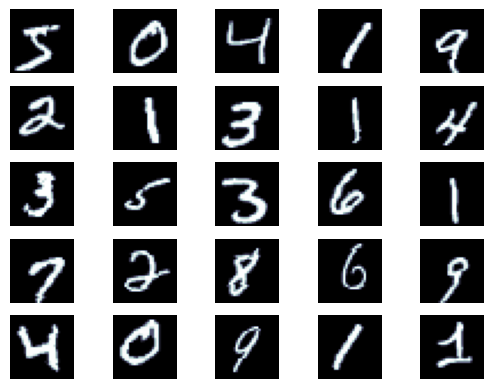

In [11]:
NUM_IMGS = 25
images = [image for image, label in [train_ds[i] for i in range(NUM_IMGS)]]
imshows(images)

In [12]:
val_ratio = 0.1
train_size = int(len(train_ds) * (1 - val_ratio))
val_size = len(train_ds) - train_size

train_ds, val_ds = data.random_split(train_ds, [train_size, val_size])

In [13]:
print(f"Number of training examples: {len(train_ds)}")
print(f"Number of validation examples: {len(val_ds)}")
print(f"Number of testing examples: {len(test_ds)}")

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


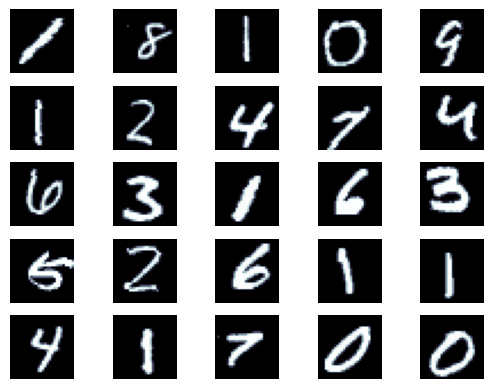

In [14]:
NUM_IMGS = 25
images = [image for image, label in [val_ds[i] for i in range(NUM_IMGS)]]
imshows(images)

In [15]:
BATCH_SIZE = 2**6

train_iterator = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
class MLP_for_MNIST(nn.Module):
    def __init__(self, input_dim, output_dim, activation) -> None:
        super().__init__()
        self.activation = activation
        self.input_fc = nn.Linear(input_dim, 256)
        self.hidden_fc = nn.Linear(256, 128)
        self.output_fc = nn.Linear(128, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h1 = self.activation(self.input_fc(x))
        h2 = self.activation(self.hidden_fc(h1))

        y_pred = self.output_fc(h2)
        return y_pred, h2

In [17]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP_for_MNIST(INPUT_DIM, OUTPUT_DIM, activation=F.relu)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 235,146 trainable parameters


In [18]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

In [19]:
EPOCHS = 10
best_valid_loss = float("inf")
for epoch in trange(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best.pt")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.404 | Train Acc: 87.34%
	 Val. Loss: 0.195 |  Val. Acc: 93.78% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.167 | Train Acc: 94.75%
	 Val. Loss: 0.151 |  Val. Acc: 95.20% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.136 | Train Acc: 95.89%
	 Val. Loss: 0.124 |  Val. Acc: 96.00% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 0.119 | Train Acc: 96.27%
	 Val. Loss: 0.120 |  Val. Acc: 96.29% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.106 | Train Acc: 96.74%
	 Val. Loss: 0.113 |  Val. Acc: 96.32% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 0.096 | Train Acc: 97.03%
	 Val. Loss: 0.089 |  Val. Acc: 97.10% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.092 | Train Acc: 97.20%
	 Val. Loss: 0.097 |  Val. Acc: 96.92% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 0.090 | Train Acc: 97.21%
	 Val. Loss: 0.100 |  Val. Acc: 96.63% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.082 | Train Acc: 97.39%
	 Val. Loss: 0.076 |  Val. Acc: 97.57% 



Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.078 | Train Acc: 97.60%
	 Val. Loss: 0.077 |  Val. Acc: 97.56% 



In [20]:
model.load_state_dict(torch.load("best.pt"))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.050 | Test Acc: 98.28%


In [21]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

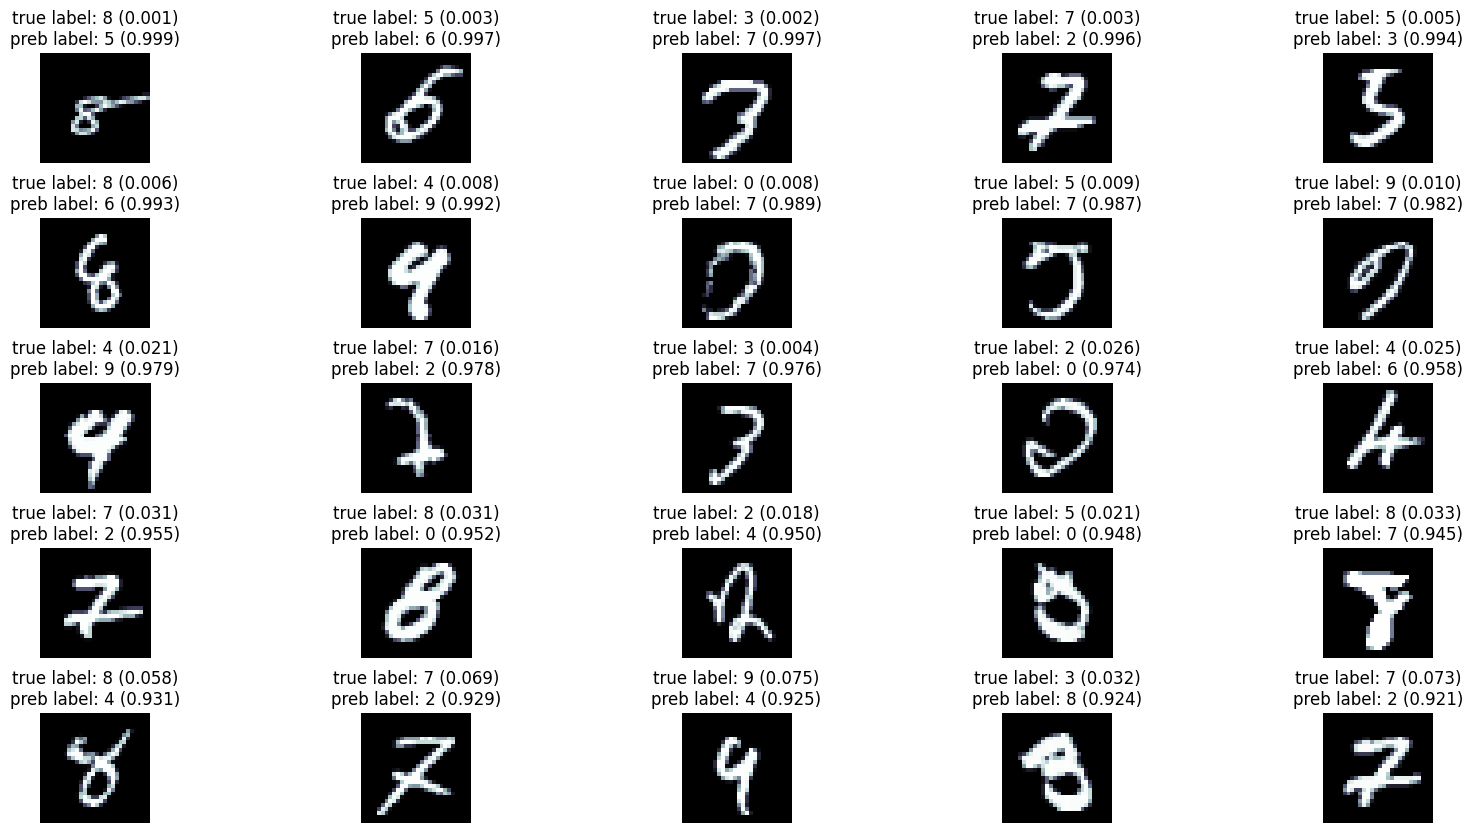

In [23]:
N_IMAGES = 25
show_most_incorrect(incorrect_examples, N_IMAGES)

In [24]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)

Representing:   0%|          | 0/844 [00:00<?, ?it/s]

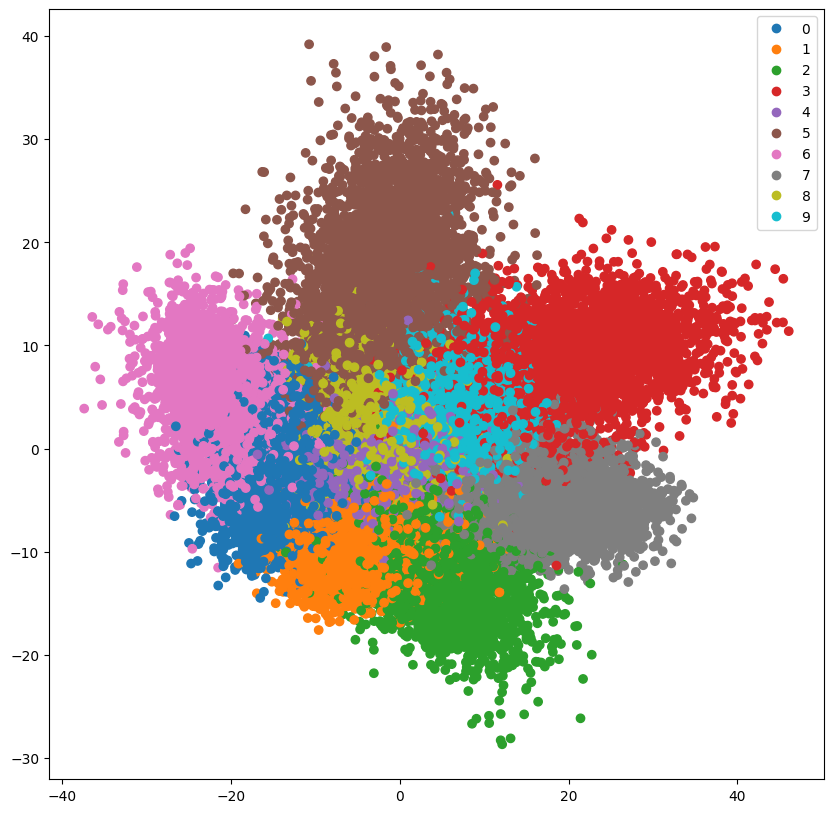

In [25]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

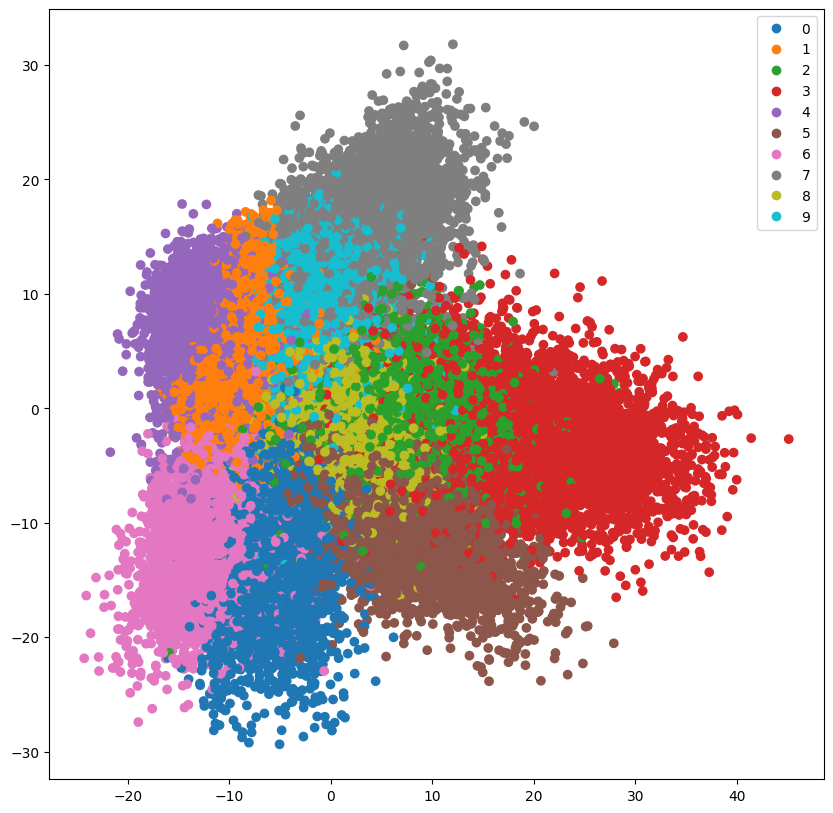

In [26]:
intermediates_pca_data = get_pca(intermediates)
plot_representations(intermediates_pca_data, labels)

In [27]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

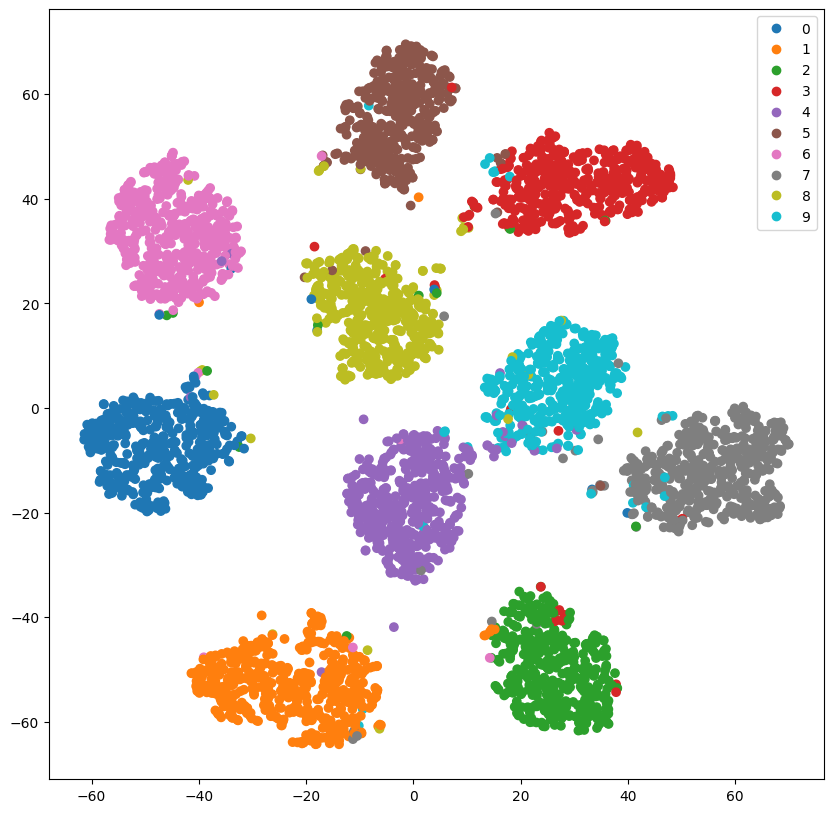

In [28]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

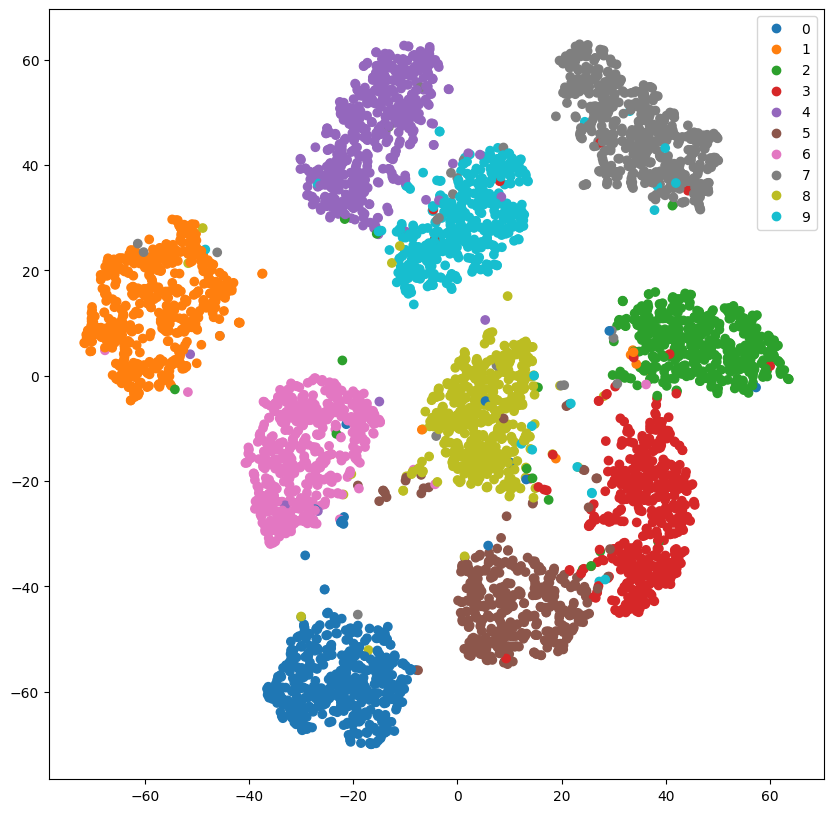

In [29]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

In [30]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)
print(f"Best image probability: {best_prob.item()*100:.2f}%")

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 99.99%


(-0.5, 27.5, 27.5, -0.5)

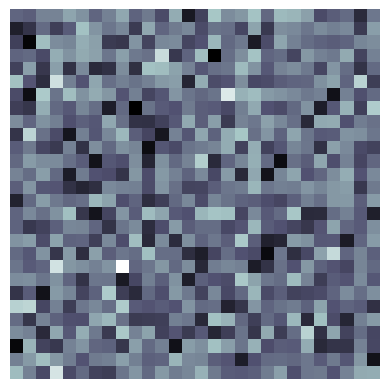

In [31]:
plt.imshow(best_image.cpu().numpy(), cmap="bone")
plt.axis("off")

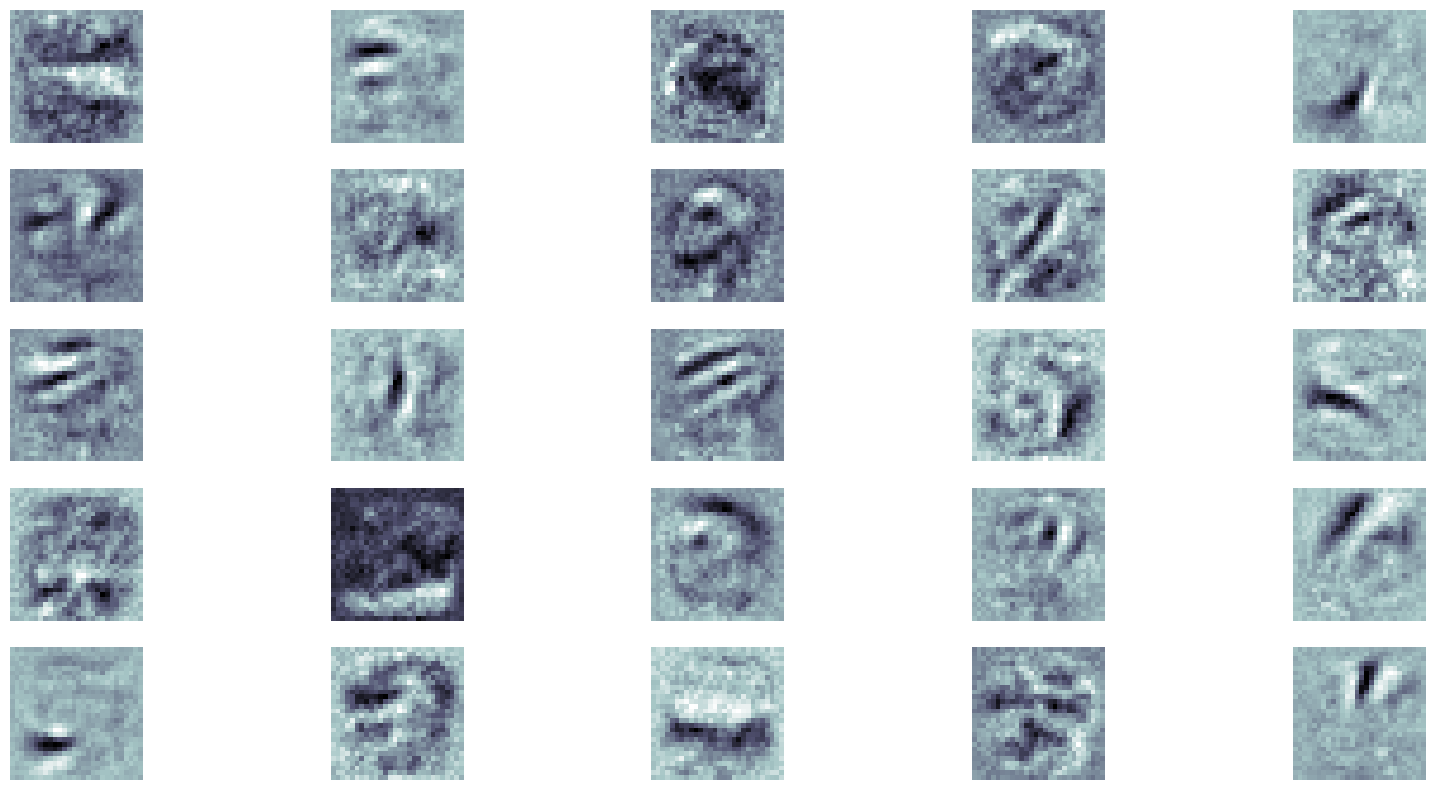

In [32]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)

# Excersize 1

1/ Thực hiện lại bài Lab03_IS_Introduction_to_Deep_Learning.ipynb và tiến hành các thay đổi sau sau đó lập bảng so sánh về Accuracy trên tập MNIST

Thêm phần tạo đa dang data Augmentation <code>(RandomHorizontalFlip, RandomZoomOut, RandomAffine with shear)</code> và hiển thị vài hình ảnh ví dụ sau khi áp dụng các transform

Thay đổi Batch Size : 32, 128, và 256

Đổi hành Activation : <code>LeakyRelu, ELU</code>


## Create class Pipeline

In [33]:
class Pipeline:
    def __init__(
        self,
        batch_size: int,
        model,
        train_transforms: tuple[str, v2.Compose],
        test_transforms: v2.Compose,
        load_weights: bool = True,
        filename_weights: str = 'best.pt'
    ) -> None:
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.train_transforms = train_transforms
        self.test_transfroms = test_transforms
        self.optimizer = optim.Adam(model.parameters())
        self.critertion = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_iterator = self.test_iterator = self.val_iterator = None
        self.load_weights = load_weights
        self.filename_weights = filename_weights

    def set_device(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)
        self.critertion = self.critertion.to(device)

    def get_mnist_dataset(self, root: str, val_ratio: float) -> tuple:
        train_ds = datasets.MNIST(
            root=root, train=True, download=False, transform=self.train_transforms[1]
        )
        test_ds = datasets.MNIST(
            root=root, train=False, download=False, transform=self.test_transfroms
        )

        train_size = int(len(train_ds) * (1 - val_ratio))
        val_size = len(train_ds) - train_size
        train_ds, val_ds = data.random_split(train_ds, [train_size, val_size])
        return train_ds, val_ds, test_ds

    def get_cifar10_dataset(self, root: str, val_ratio: float) -> tuple:
        train_ds = datasets.CIFAR10(
            root=root, train=True, download=False, transform=self.train_transforms[1]
        )
        test_ds = datasets.CIFAR10(
            root=root, train=False, download=False, transform=self.test_transfroms
        )

        train_size = int(len(train_ds) * (1 - val_ratio))
        val_size = len(train_ds) - train_size
        train_ds, val_ds = data.random_split(train_ds, [train_size, val_size])
        return train_ds, val_ds, test_ds

    def set_iterator(self, name: str) -> None:
        match name.lower():
            case "mnist":
                train_ds, val_ds, test_ds = self.get_mnist_dataset(
                    root=ROOT, val_ratio=0.1
                )
            case "cifar10":
                train_ds, val_ds, test_ds = self.get_cifar10_dataset(
                    root=ROOT, val_ratio=0.1
                )
        self.train_iterator = data.DataLoader(
            train_ds, batch_size=self.batch_size, shuffle=True
        )
        self.val_iterator = data.DataLoader(
            val_ds, batch_size=self.batch_size, shuffle=True
        )
        self.test_iterator = data.DataLoader(
            test_ds, batch_size=self.batch_size, shuffle=True
        )

    def fit(self, activation, epochs: int = 10, show_logs: bool = False) -> None:
        if self.load_weights and os.path.exists(self.filename_weights):
            self.model.load_state_dict(torch.load(self.filename_weights))
        else:
#             summary(self.model, (1, 32, 32))
            best_valid_loss = float("inf")
            for epoch in trange(epochs):
                start = time.monotonic()

                loss, acc = train(
                    self.model,
                    self.train_iterator,
                    self.optimizer,
                    self.critertion,
                    self.device,
                )
                val_loss, val_acc = evaluate(
                    self.model, self.val_iterator, self.critertion, self.device
                )

                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    torch.save(self.model.state_dict(), self.filename_weights)
                end = time.monotonic()
                epoch_mins, epoch_secs = epoch_time(start, end)
                if show_logs and epoch + 1 == epochs:
                    print(
                        f"Batch size: {self.batch_size} | Activation: {activation.__name__} | Transform: {self.train_transforms[0]}"
                    )
                    print(
                        f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s"
                    )
                    print(f"\tTrain Loss: {loss:.3f} | Train Acc: {acc*100:.2f}%")
                    print(
                        f"\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%"
                    )

    def evaluate(self, activation, show_logs: bool = True) -> tuple[float, float]:
        self.model.load_state_dict(torch.load(self.filename_weights))
        test_loss, test_acc = evaluate(
            self.model, self.test_iterator, self.critertion, self.device
        )
        if show_logs:
            print(
                f"Batch size: {self.batch_size} | Activation: {activation.__name__} | Transform: {self.train_transforms[0]}"
            )
            print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")
        return test_loss, test_acc

    def predict(self, display_most_incorrect: bool = False) -> list:
        images, labels, probs = get_predictions(
            self.model, self.test_iterator, self.device
        )
        pred_labels = torch.argmax(probs, 1)
        corrects = torch.eq(labels, pred_labels)
        incorrect_examples = []

        for image, label, prob, correct in zip(images, labels, probs, corrects):
            if not correct:
                incorrect_examples.append((image, label, prob))
        incorrect_examples.sort(
            key=lambda x: torch.max(x[2], dim=0).values, reverse=True
        )

        if display_most_incorrect:
            show_most_incorrect(incorrect_examples, n_images=16)

        return incorrect_examples
    def return_model(self):
        return self.model

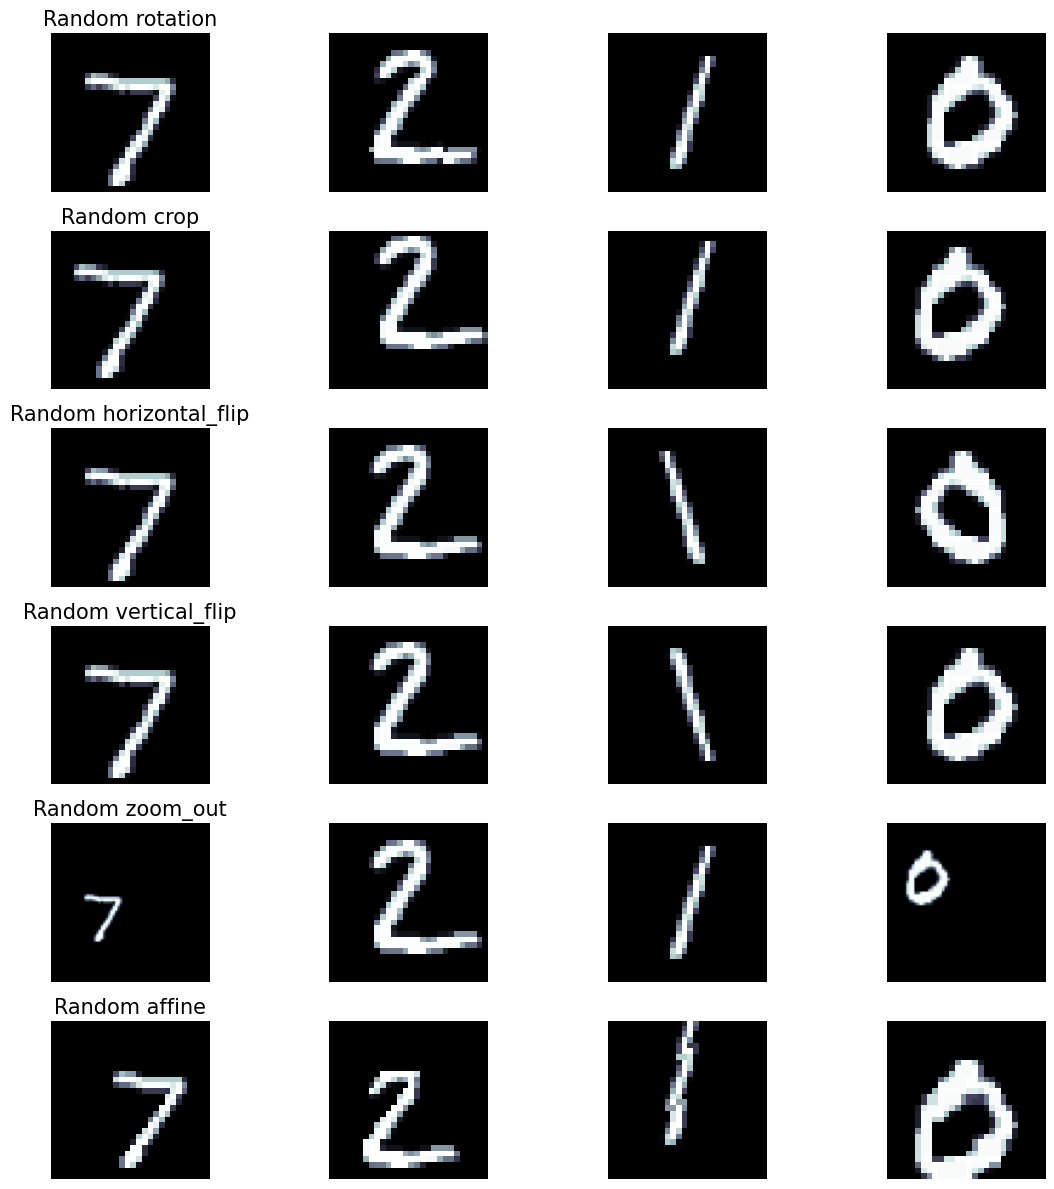

In [34]:
# Take test data from MNIST for showing transformed images
experiment_transform_ds = datasets.MNIST(
    ROOT, train=False, download=False, transform=v2.ToTensor()
)
experiment_transformations = Counter(
    rotation=v2.RandomRotation(degrees=5, fill=(0,)),
    crop=v2.RandomCrop(size=28, padding=2),
    horizontal_flip=v2.RandomHorizontalFlip(p=0.5),
    vertical_flip=v2.RandomVerticalFlip(p=0.1),
    zoom_out=v2.RandomZoomOut(side_range=(1.5, 3.0), fill=(0,)),
    affine=v2.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2), translate=(0.2, 0.2)),
)


n_images = 4
fig, ax = plt.subplots(len(experiment_transformations), n_images, figsize=(12, 12))

for idx, (key, transformation) in enumerate(experiment_transformations.items()):
    images = [
        experiment_transform_ds[i][0] for i in range(n_images)
    ]  # Load images as tensors
    transformed_images = [transformation(image) for image in images]

    for j, image in enumerate(transformed_images):
        image = functional.convert_image_dtype(image, dtype=torch.float32)
        ax[idx, j].imshow(
            image.permute(1, 2, 0), cmap="bone"
        )  # permute to make it [H, W, C] and display
        ax[idx, j].axis("off")
    ax[idx, 0].set_title("Random " + str(key), fontsize=15)

plt.tight_layout()
plt.show()

In [35]:
experiment_transformations.values()

dict_values([RandomRotation(degrees=[-5.0, 5.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=(0,)), RandomCrop(size=(28, 28), padding=[2, 2, 2, 2], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5), RandomVerticalFlip(p=0.1), RandomZoomOut(p=0.5, fill=(0,), side_range=(1.5, 3.0)), RandomAffine(degrees=[0.0, 0.0], translate=(0.2, 0.2), scale=(0.8, 1.2), shear=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, fill=0)])

## Take result of excersize 1

In [36]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [37]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
BATCH_SIZE = [32, 128, 256]
activations = [F.relu, F.leaky_relu, F.elu]

train_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.RandomRotation(5, fill=(0,)),
        v2.RandomCrop(size=28, padding=2),
        v2.ToImage(),
        v2.Resize((28, 28)),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=[mean], std=[std]),
    ]
)

required_train_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.RandomRotation(degrees=5, fill=(0,)),
        v2.RandomCrop(size=28, padding=2),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.1),
        v2.RandomZoomOut(side_range=(1.5, 3.0), fill=(0,)),
        v2.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2), translate=(0.2, 0.2)),
        v2.ToImage(),
        v2.Resize((28, 28)),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=[mean], std=[std]),
    ]
)

dict_train_transforms = Counter(
    default=train_transforms, required=required_train_transforms
)
results = pd.DataFrame(columns=['batch_size', 'activation', 'transform', 'loss', 'score'])

for batch_size in BATCH_SIZE:
    for activation in activations:
        for key, transform in dict_train_transforms.items():
            p1 = Pipeline(
                batch_size=batch_size,
                model=MLP_for_MNIST(INPUT_DIM, OUTPUT_DIM, activation),
                train_transforms=(key, transform),
                test_transforms=test_transforms,
                load_weights=False,
            )
            p1.set_iterator(name="mnist")
            p1.set_device()
            p1.fit(activation=activation, show_logs=False, epochs=10)
            test_loss, test_acc = p1.evaluate(activation=activation, show_logs=False)
            results = results._append(pd.Series([batch_size, activation.__name__, key, round(test_loss, 4), round(test_acc, 4)],
                                                index=results.columns),
                                      ignore_index=True)

print(p1.return_model())
display(results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MLP_for_MNIST(
  (input_fc): Linear(in_features=784, out_features=256, bias=True)
  (hidden_fc): Linear(in_features=256, out_features=128, bias=True)
  (output_fc): Linear(in_features=128, out_features=10, bias=True)
)


,batch_size,activation,transform,loss,score
0,32,relu,default,0.0729,0.9783
1,32,relu,required,0.3434,0.8904
2,32,leaky_relu,default,0.0622,0.9800
3,32,leaky_relu,required,0.3132,0.8996
4,32,elu,default,0.0544,0.9810
5,32,elu,required,0.3443,0.8844
6,128,relu,default,0.0567,0.9801
7,128,relu,required,0.3388,0.8932
8,128,leaky_relu,default,0.0614,0.9815
9,128,leaky_relu,required,0.3280,0.8988


# Excersize 2

2/ Thực hiện lại tương tự các bước trên nhưng apply cho Dataset mới là CIFAR10 dataset


100%|██████████| 170498071/170498071 [00:04<00:00, 42071583.34it/s]


Extracting .data/cifar-10-python.tar.gz to .data


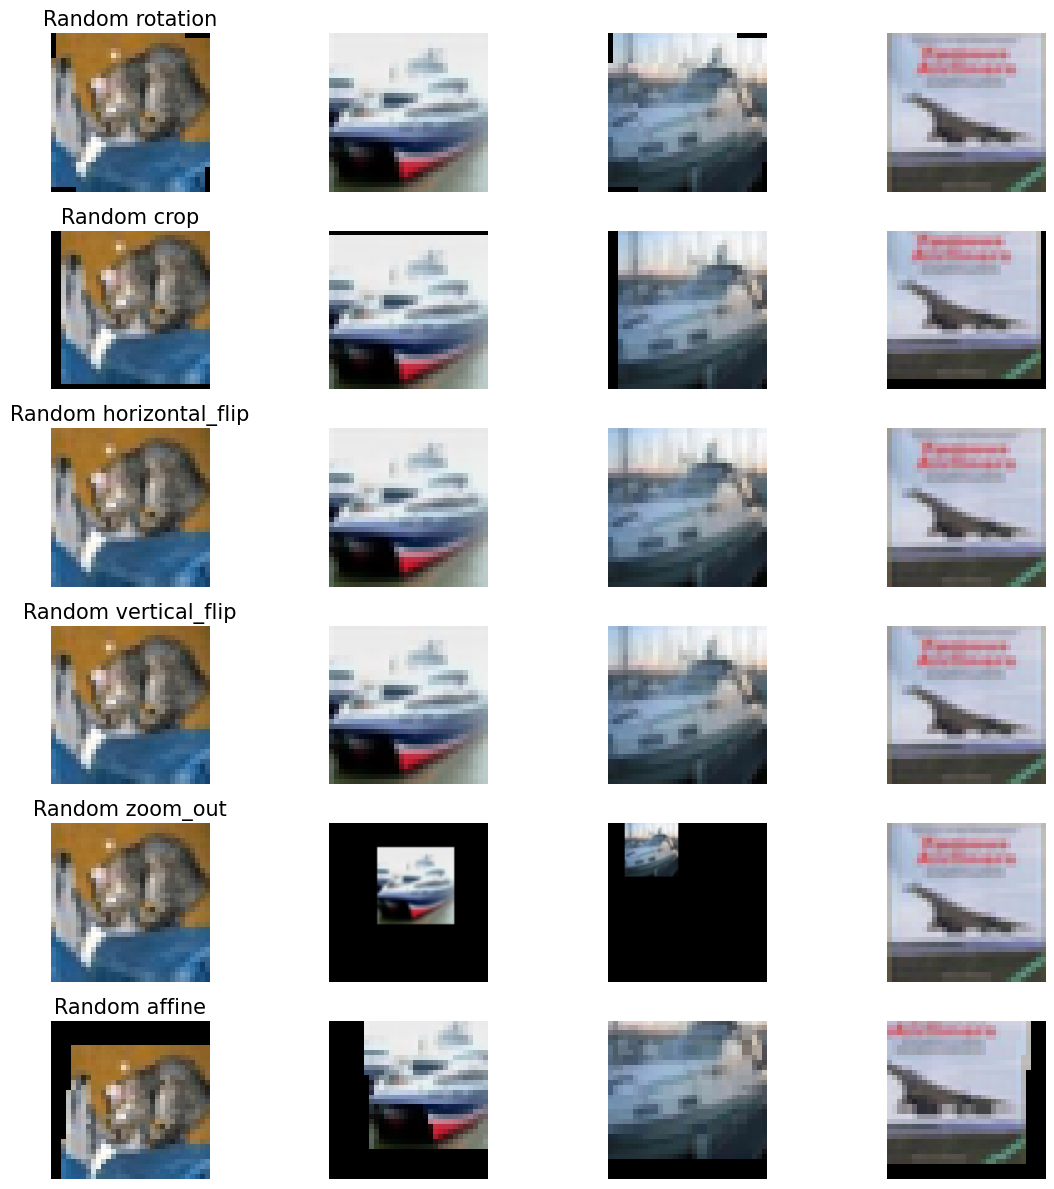

In [38]:
# Take test data from MNIST for showing transformed images
experiment_transform_ds = datasets.CIFAR10(
    ROOT, train=False, download=True, transform=v2.ToTensor()
)
experiment_transformations = Counter(
    rotation=v2.RandomRotation(degrees=5, fill=(0,)),
    crop=v2.RandomCrop(size=32, padding=2),
    horizontal_flip=v2.RandomHorizontalFlip(p=0.5),
    vertical_flip=v2.RandomVerticalFlip(p=0.1),
    zoom_out=v2.RandomZoomOut(side_range=(1.5, 3.0), fill=(0,)),
    affine=v2.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2), translate=(0.2, 0.2)),
)


n_images = 4
fig, ax = plt.subplots(len(experiment_transformations), n_images, figsize=(12, 12))

for idx, (key, transformation) in enumerate(experiment_transformations.items()):
    images = [
        experiment_transform_ds[i][0] for i in range(n_images)
    ]  # Load images as tensors
    transformed_images = [transformation(image) for image in images]

    for j, image in enumerate(transformed_images):
        image = functional.convert_image_dtype(image, dtype=torch.float32)
        ax[idx, j].imshow(
            image.permute(1, 2, 0), cmap="bone"
        )  # permute to make it [H, W, C] and display
        ax[idx, j].axis("off")
    ax[idx, 0].set_title("Random " + str(key), fontsize=15)

plt.tight_layout()
plt.show()

In [39]:
train_ds = datasets.CIFAR10(ROOT, train=True, download=False)
mean = train_ds.data.mean() / 255
std = train_ds.data.std() / 255

print(f"Mean: {mean}, \n Std: {std}")

Mean: 0.4733630004850899, 
 Std: 0.2515689250632208


In [40]:
INPUT_DIM = 32 * 32
OUTPUT_DIM = 10

train_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.RandomRotation(5, fill=(0,)),
        v2.RandomCrop(32, padding=2),
        v2.ToImage(),
        v2.Resize((32, 32)),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=[mean], std=[std]),
    ]
)

required_train_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.RandomRotation(degrees=5, fill=(0,)),
        v2.RandomCrop(size=32, padding=2),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.1),
        v2.RandomZoomOut(side_range=(1.5, 3.0), fill=(0,)),
        v2.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2), translate=(0.2, 0.2)),
        v2.ToImage(),
        v2.Resize((32, 32)),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=[mean], std=[std]),
    ]
)

dict_train_transforms = Counter(
    default=train_transforms, required=required_train_transforms,
)

test_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=1),
        v2.ToTensor(),
        v2.Normalize(mean=[mean], std=[std])
    ]
)

## Recreate MLP

In [41]:
class MLP_for_CIFAR10(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_units, activation):
        super(MLP_for_CIFAR10, self).__init__()
        h1, h2, h3, h4, h5 = n_hidden_units
        self.activation = activation

        # Add Linear layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, output_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [42]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Take result of excersize 2

In [43]:
results = pd.DataFrame(columns=['batch_size', 'activation', 'transform', 'loss', 'score'])
INPUT_DIM = 32 * 32
OUTPUT_DIM = 10
BATCH_SIZE = [32, 128, 256]
activations = [F.relu, F.leaky_relu, F.elu]
for batch_size in BATCH_SIZE:
    for activation in activations:
        for key, transform in dict_train_transforms.items():
            p2 = Pipeline(
                batch_size=batch_size,
                model=MLP_for_CIFAR10(n_hidden_units=(5000, 4000, 2500, 1000, 250), input_dim=INPUT_DIM, output_dim=OUTPUT_DIM, activation=activation),
                train_transforms=(key, transform),
                test_transforms=test_transforms,
                load_weights=False,
                filename_weights='best_cifar10.pt'
            )
            p2.set_iterator(name="cifar10")
            p2.set_device()
            p2.fit(activation, show_logs=False, epochs=10)
            test_loss, test_acc = p2.evaluate(activation, show_logs=False)
            results = results._append(pd.Series([batch_size, activation.__name__, key, round(test_loss, 4), round(test_acc, 4)],
                                                index=results.columns),
                                      ignore_index=True)
print(p2.return_model())
display(results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MLP_for_CIFAR10(
  (fc1): Linear(in_features=1024, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=4000, bias=True)
  (fc3): Linear(in_features=4000, out_features=2500, bias=True)
  (fc4): Linear(in_features=2500, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=250, bias=True)
  (fc6): Linear(in_features=250, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


,batch_size,activation,transform,loss,score
0,32,relu,default,1.8563,0.3371
1,32,relu,required,2.1348,0.2101
2,32,leaky_relu,default,1.9382,0.2838
3,32,leaky_relu,required,11.2016,0.1306
4,32,elu,default,1.8234,0.3330
5,32,elu,required,2.3113,0.0998
6,128,relu,default,1.7850,0.3715
7,128,relu,required,2.0946,0.2437
8,128,leaky_relu,default,1.7490,0.3854
9,128,leaky_relu,required,2.1441,0.2012


## Test another model

In [44]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [45]:
results = pd.DataFrame(columns=['batch_size', 'transform', 'loss', 'score'])
INPUT_DIM = 32 * 32
OUTPUT_DIM = 10
BATCH_SIZE = [256]
for batch_size in BATCH_SIZE:
    for key, transform in dict_train_transforms.items():
        p3 = Pipeline(
            batch_size=batch_size,
            model=ResNet9(1, OUTPUT_DIM),
            train_transforms=(key, transform),
            test_transforms=test_transforms,
            load_weights=False,
            filename_weights='best_cifar10.pt'
        )
        p3.set_iterator(name="cifar10")
        p3.set_device()
        p3.fit(F.relu, show_logs=False, epochs=10)
        test_loss, test_acc = p3.evaluate(F.relu, show_logs=False)
        results = results._append(pd.Series([batch_size, key, round(test_loss, 4), round(test_acc, 4)],
                                            index=results.columns),
                                  ignore_index=True)
print(p3.return_model())
display(results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

,batch_size,transform,loss,score
0,256,default,0.5085,0.8419
1,256,required,0.6950,0.7635
